In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import os
import cv2
#from tensorflow.keras.applications.resnet import preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model


name="HAKATON"
target_shape=(224,224)
root_dir_weights=r"D:\WEIGHTS"
ROOT = r"D:\DATASET"
name_classes=os.listdir(ROOT)

batch_size=64

In [42]:
print(tf.__version__, np.__version__)

2.6.0 1.23.5


In [2]:
def preprocess_input(data):
    return data

<p style="text-align:center"><font size="24">Обработка датасета</font></p>

In [3]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)


In [4]:
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass,'images')
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r"D:\DATASET"
good_exts=['jpg', 'jpeg' ]
#bad_file_list, bad_ext_list=check_images(source_dir, good_exts)

In [5]:
def read_image(index,shape=target_shape):
    path = os.path.join(ROOT, index[1])
    image = PIL.Image.open(path)
    image = image.resize(shape)
    return np.array(image)

def get_images(directory):
    dataset={}
    folders = os.listdir(directory)
    for folder in folders:
        dataset[folder]=os.listdir(os.path.join(directory, folder,'images'))
    return dataset

def create_dataset(images_on_dict):
    dataset=[]
    for class_ in images_on_dict.keys():
        for name_image in images_on_dict[class_]:
            dataset.append([class_,os.path.join(class_,'images',name_image)])
    return dataset

In [6]:
names_of_images=get_images(ROOT)
for i in range(len(name_classes)):
    print(f'amount of {name_classes[i]} images',len(names_of_images[name_classes[i]]))

amount of klikun images 3025
amount of malyiy images 2997
amount of shipun images 3011


In [7]:
raw_dataset=create_dataset(names_of_images)

In [8]:
def pick_random_image(dataset,name):
    class_,img=random.choice(dataset)
    while class_!=name:
        class_,img=random.choice(dataset)
    return [class_,img]

In [9]:
def visualize(dataset):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3,3)
    for i in range(3):
        axs[0, 0].set_title(name_classes[0])
        axs[0, 1].set_title(name_classes[1])
        axs[0, 2].set_title(name_classes[2])
        show(axs[i, 0], read_image(pick_random_image(dataset,name_classes[0])))
        show(axs[i, 1], read_image(pick_random_image(dataset,name_classes[1])))
        show(axs[i, 2], read_image(pick_random_image(dataset,name_classes[2])))


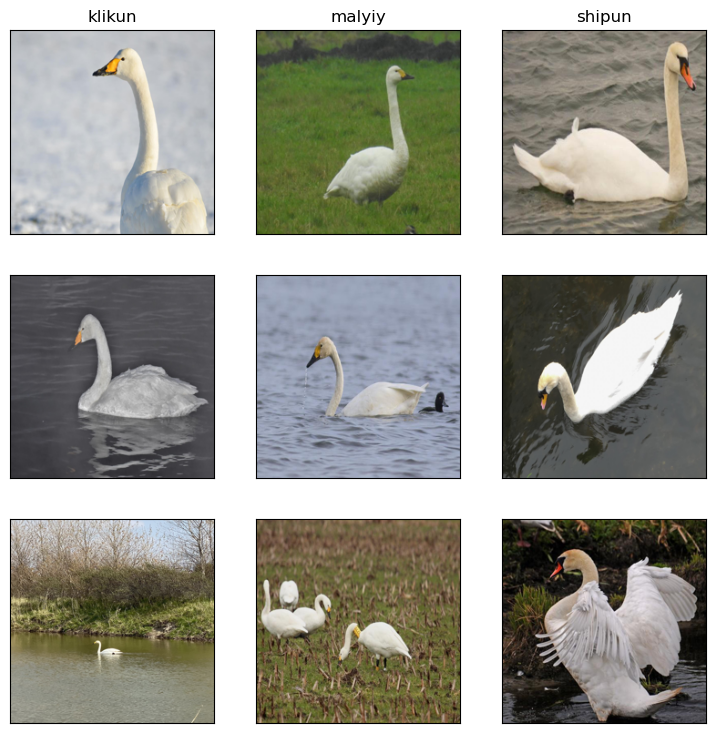

In [10]:
visualize(raw_dataset)

In [11]:
random.shuffle(raw_dataset)

In [12]:
one_hot_dict={name_classes[0]:0,name_classes[1]:1,name_classes[2]:2}
for ob in raw_dataset:
    ob[0]=one_hot_dict[ob[0]]

In [13]:
def get_Y_X(raw_dataset):
    Y=[]
    X=[]
    for object_ in raw_dataset:
        Y.append(object_[0])
        X.append(object_[1])
    return Y,X

In [14]:
Y,X=get_Y_X(raw_dataset)

In [15]:
Y_enc = tf.keras.utils.to_categorical(Y, num_classes=3)

In [16]:
def split_dataset(X,Y, split=0.9):
    num_train = int(len(Y)*split)
    
    train_X=X[:num_train]
    train_Y=Y[:num_train]
    test_X=X[num_train:]
    test_Y=Y[num_train:]
    
    return [np.array(train_X),np.array(train_Y),np.array(test_X),np.array(test_Y)]

train_X,train_Y,test_X,test_Y = split_dataset(X,Y_enc, split=0.9)
val_X,val_Y=test_X[:10],test_Y[:10]
print(f'len of train data: {len(train_X)}')
print(f'len of test data: {len(test_X)}')
print(f'len of val data: {len(val_X)}')

len of train data: 8129
len of test data: 904
len of val data: 10


In [17]:
def preprocess_image(X,Y):
    image_string = tf.io.read_file(ROOT+'\\'+X)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    X = tf.image.resize(image, target_shape)
    return (X,Y)

In [18]:

def preprocess_image(X,Y):
    image_string = tf.io.read_file(ROOT+'\\'+X)
    image = tf.io.decode_jpeg(image_string, channels=3)
    #image = tf.image.convert_image_dtype(image, tf.float32)
    X = tf.image.resize(image, target_shape)
    return (X,Y)

In [19]:
#for a in preprocess_image("klikun\\images\\24_Mizinenko_0813.jpg",[1])[0]:
#    print(a)

In [20]:
_AUTO = tf.data.AUTOTUNE
def create_pipline(Y,X, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_image)
    dataset = dataset.batch(batch_size)
    dataset=dataset.prefetch(_AUTO)
    return dataset

In [21]:
train_dataset=create_pipline(train_Y,train_X,batch_size)
test_dataset=create_pipline(test_Y,test_X,batch_size)
val_dataset=create_pipline(val_Y,val_X,batch_size)

<p style="text-align:center"><font size="24">Создание нейросети</font></p>

In [24]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,BatchNormalization

In [31]:
base_cnn = MobileNetV2(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
block1_input_img=Conv2D(10, (1,1), padding='same', activation='relu')(base_cnn.output)
#block1_input_img = layers.Flatten()(base_cnn.output)
block1_layer_1_1 = Conv2D(5, (1,1), padding='same', activation='relu')(block1_input_img)
block1_layer_1_2 = Conv2D(5, (3,3), padding='same', activation='relu')(block1_layer_1_1)

block1_layer_2_1 = Conv2D(5, (1,1), padding='same', activation='relu')(block1_input_img)
block1_layer_2_2 = Conv2D(5, (5,5), padding='same', activation='relu')(block1_layer_2_1)

block1_layer_3_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(block1_input_img)
block1_layer_3_2 = Conv2D(5, (1,1), padding='same', activation='relu')(block1_layer_3_1)

block1_out_img= tf.keras.layers.concatenate([block1_layer_1_2, block1_layer_2_2, block1_layer_3_2], axis = 3)
block2_input_img = BatchNormalization()(block1_out_img)
block2_layer_1_1 = Conv2D(2, (1,1), padding='same', activation='relu')(block2_input_img)
block2_layer_1_2 = Conv2D(2, (3,3), padding='same', activation='relu')(block2_layer_1_1)

block2_layer_2_1 = Conv2D(2, (1,1), padding='same', activation='relu')(block2_input_img)
block2_layer_2_2 = Conv2D(2, (5,5), padding='same', activation='relu')(block2_layer_2_1)

block2_layer_3_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(block2_input_img)
block2_layer_3_2 = Conv2D(2, (1,1), padding='same', activation='relu')(block2_layer_3_1)

block2_output_img = tf.keras.layers.concatenate([block2_layer_1_2, block2_layer_2_2, block2_layer_3_2], axis = 3)
block3_input_img = BatchNormalization()(block2_output_img)

flatten = layers.Flatten()(block3_input_img)
output = Dense(3, activation="softmax")(flatten)

heart = Model(base_cnn.input, output, name="heart")

trainable = False
for layer in base_cnn.layers:
    layer.trainable = trainable

In [32]:
_input = layers.Input(name="Input", shape=target_shape + (3,))
out=heart(_input)
modelnet = Model(
    inputs=_input, outputs=out
)

In [33]:
class SwanModel(Model):

    def __init__(self, modelnet,input_shape):
        super().__init__()
        self.modelnet = modelnet
        self.loss_tracker = metrics.Mean(name="loss")
        self.build((None,) + input_shape)

    def call(self, inputs):
        return self.modelnet(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.modelnet.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.modelnet.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        
        y_pred =self.modelnet(preprocess_input(data[0]))
        loss=tf.losses.categorical_crossentropy(data[1],y_pred)
        return loss
    
    '''
    def predict_image(self,way_to_file):
        image_string = tf.io.read_file(way_to_file)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, target_shape).numpy()
        image = np.resize(image,[1,*target_shape,3])
        return self.modelnet(image.numpy)
    '''

    @property
    def metrics(self):
        return [self.loss_tracker]

In [34]:
Swan_rec_Model = SwanModel(modelnet,input_shape=target_shape+(3,))

In [35]:
Swan_rec_Model.compile(optimizer=Adam(0.001))

In [36]:
history=Swan_rec_Model.fit(train_dataset, epochs=10,validation_data=test_dataset,batch_size=batch_size)
Swan_rec_Model.save_weights(os.path.join(root_dir_weights, name+"-final"))

Epoch 1/10
128/128 [==============================] - 182s 1s/step - loss: 0.9831 - val_loss: 0.9081
Epoch 2/10
128/128 [==============================] - 11s 87ms/step - loss: 0.8720 - val_loss: 0.8726
Epoch 3/10
128/128 [==============================] - 11s 87ms/step - loss: 0.8133 - val_loss: 0.8668
Epoch 4/10
128/128 [==============================] - 11s 87ms/step - loss: 0.7798 - val_loss: 0.9071
Epoch 5/10
128/128 [==============================] - 11s 88ms/step - loss: 0.7387 - val_loss: 0.8738
Epoch 6/10
128/128 [==============================] - 11s 87ms/step - loss: 0.7092 - val_loss: 0.8917
Epoch 7/10
128/128 [==============================] - 11s 87ms/step - loss: 0.6905 - val_loss: 1.0062
Epoch 8/10
128/128 [==============================] - 11s 88ms/step - loss: 0.6476 - val_loss: 0.9675
Epoch 9/10
128/128 [==============================] - 11s 87ms/step - loss: 0.6228 - val_loss: 0.9973
Epoch 10/10
128/128 [==============================] - 11s 88ms/step - loss: 0.5885

<p style="text-align:center"><font size="24">Анализ нейросети</font></p>

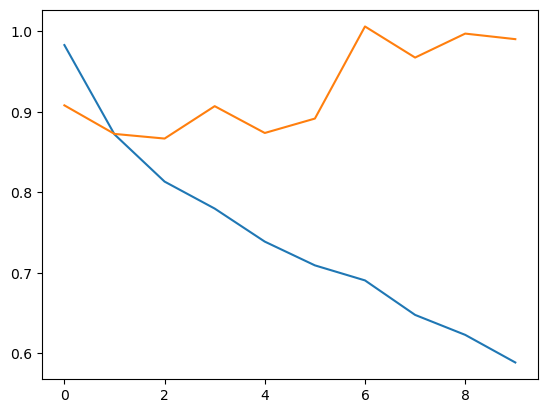

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [38]:
Swan_rec_Model.compute_output_shape(input_shape=(None,*target_shape,3))
Swan_rec_Model.save(os.path.join(root_dir_weights, name+"-inal"))

INFO:tensorflow:Assets written to: D:\WEIGHTS\HAKATON-inal\assets


D:\anaconda\envs\FACE_REC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [40]:
def test_check(dataset):
    iterator=dataset.as_numpy_iterator()
    prediction_list=np.array([])
    for data in iterator:
        y_true=data[1]
        y_pred=Swan_rec_Model.predict(data[0])
        prediction=y_true.argmax(axis=1)==y_pred.argmax(axis=1)
        prediction_list=np.concatenate((prediction_list, prediction), axis=0)
    return np.array(prediction_list)

def test_check1(dataset):
    iterator=dataset.as_numpy_iterator()
    y_true_list=np.array([])
    y_predict_list=np.array([])
    for data in iterator:
        y_true=data[1]
        y_pred=Swan_rec_Model.predict(data[0])
        y_true_list=np.concatenate((y_true_list, y_true.argmax(axis=1)), axis=0)
        y_predict_list=np.concatenate((y_predict_list, y_pred.argmax(axis=1)), axis=0)
        
    return [y_true_list,y_predict_list]
def ModelMetrics(dataset):
    
    true,pred=test_check1(dataset)

    print(f"\nТочность: {accuracy_score(true, pred)}\n")
        
    cf_matrix = confusion_matrix(true, pred) 
    cf_matrix = np.round(cf_matrix/ np.sum(cf_matrix) *100,2)


    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '')
                
    plt.xlabel("Предсказанный класс", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Настоящий класс"   , fontdict = {'size':14}, labelpad = 10)


Точность: 0.5984513274336283



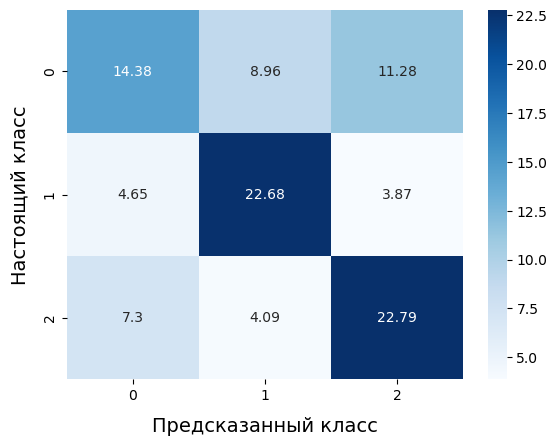

In [41]:
ModelMetrics(test_dataset)

<p style="text-align:center"><font size="24">Загрузка модели</font></p>

In [ ]:
way_to_model=r"D:\WEIGHTS\HAKATON-inal"
Model = keras.models.load_model(way_to_model)
def FINAL(Model,way_to_img):
    image_string = tf.io.read_file(way_to_img)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    X = tf.image.resize(image, target_shape)
    image = np.resize(image,[1,*target_shape,3])
    gg= Model.predict(image)
    print(gg)


In [ ]:
FINAL(Model,r"D:\DATASET\klikun\images\24_Mizinenko_0813.jpg")

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(heart, show_shapes=True, show_layer_names=True)